# Run Experiment

This notebook runs a benchmark on a given system.  In order to run an experiment with a new system, you only need to do two things:
- Implement the `offline_processing()` and `online_processing()` functions in a jupyter notebook for the new system.  You can use 02a_simpleOfflineDTW.ipynb as a template.
- Import the notebook containing the system's implementation into this notebook as a python package.

This notebook will run an entire benchmark using the specified system, and save the hypotheses to a specified output directory.

In [1]:
import import_ipynb
import numpy as np
import os.path
import system_utils
from tqdm.notebook import tqdm
from pathlib import Path
from multiprocessing import Pool

The following cell should be modified to use the desired system of interest:

importing Jupyter notebook from System_ISA.ipynb
importing Jupyter notebook from System_OfflineDTW.ipynb
importing Jupyter notebook from align_tools.ipynb


/home/kdey/ttmp/micromamba/envs/PianoConcertoAccompaniment/lib/python3.9/site-packages/nbformat/__init__.py:92: MissingIDFieldWarning: Code cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


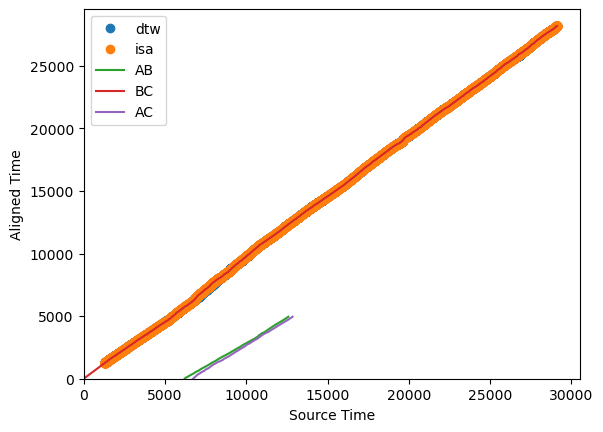

In [2]:
import System_ISA as system  # replace this with new system

# system parameters
EXP_NAME = 'ISA_CHROMA' # experiment name, e.g. offlineDTW_train
hop_size = 512
sr = 22050
dtw_steps = np.array([1,1,1,2,2,1]).reshape((-1,2))
dtw_weights = np.array([1,1,2])
use_multiprocessing = False

In [3]:
# don't change
SCENARIOS_ROOT_DIR = 'scenarios'
EXP_ROOT_DIR = f'experiments/{EXP_NAME}'
CACHE_ROOT_DIR = f'{EXP_ROOT_DIR}/cache'
SCENARIOS_SUMMARY = f'{SCENARIOS_ROOT_DIR}/scenarios.summary'

In [4]:
def getCacheDir(d, scenario_id):
    '''
    Returns the filepath of the cache directory for the given scenario id.  Note that the cache directory
    can be shared as long as the orchestra and full mix files match, so its naming specifies information
    from both.
    
    Inputs
    d: dictionary summarizing the information in the scenarios.summary file
    scenario_id: the identifier of the scenario of interest (e.g. s1)
    '''
    
    o_id = os.path.splitext(os.path.basename(d[scenario_id]['o']))[0] # e.g. rach2_mov1_O1
    po_id = os.path.splitext(os.path.basename(d[scenario_id]['po']))[0] # e.g. rach2_mov1_PO1
    cache_id = o_id + '_' + po_id.split('_')[-1] # e.g. rach2_mov1_O1_PO1
    cache_dir = f'{CACHE_ROOT_DIR}/{cache_id}' 
    
    return cache_dir

The following function runs the offline processing stage.  You only need to edit the arguments to the `offline_processing()` function.

In [5]:
def runOfflineProcessing(cache = None):
    '''
    Runs the offline processing component (only) for every scenario using the specified system.
    If the cache directory for the scenario already exists, the offline processing for that scenario
    will be skipped.
    
    Inputs
    cache: specify a cache directory to simply copy over, will bypass the offline processing stage
    '''
    
    # setup
    if not os.path.exists(EXP_ROOT_DIR):
        os.makedirs(EXP_ROOT_DIR)
    if cache is None:
        if not os.path.exists(CACHE_ROOT_DIR): # create if not there, leave it alone if already present
            os.mkdir(CACHE_ROOT_DIR)
    else:
        if os.path.exists(CACHE_ROOT_DIR): # replace with the specified cache directory
            os.system(f'rm -rf {CACHE_ROOT_DIR}')
        os.system(f'cp -r {cache} {CACHE_ROOT_DIR}')
    
    # run offline processing component for each scenario
    d = system_utils.get_scenario_info(SCENARIOS_SUMMARY)    
    for i in tqdm(range(len(d))):
        
        scenario_id = f's{i+1}'
        scenario_dir = f'{SCENARIOS_ROOT_DIR}/{scenario_id}'
        cache_dir = getCacheDir(d, scenario_id)
        if os.path.exists(cache_dir):
            # print(f'Skipping offline processing for {scenario_id} -- cache already exists.')
            system.verify_cache_dir(cache_dir) # optional: verify that cache directory has required files
        else:
            # print(f'Running offline processing for {scenario_id}')
            # system.offline_processing(scenario_dir, cache_dir, hop_size, dtw_steps, dtw_weights) # offlineDTW and MATCH
            # system.offline_processing(scenario_dir, cache_dir, hop_size, dtw_steps, dtw_weights, Path(cache_dir).parent, 'SPL-TTA') # separatedMatch
            system.offline_processing(scenario_dir, cache_dir, hop_size, 'chroma') # ISA

In [6]:
runOfflineProcessing()

  0%|          | 0/140 [00:00<?, ?it/s]

/home/kdey/ttmp/micromamba/envs/PianoConcertoAccompaniment/lib/python3.9/site-packages/hmc_mir/align/isa.py:54: RuntimeWarning: invalid value encountered in divide
  result = cost / row_sums[:, None]
/home/kdey/ttmp/micromamba/envs/PianoConcertoAccompaniment/lib/python3.9/site-packages/hmc_mir/align/isa.py:54: RuntimeWarning: invalid value encountered in divide
  result = cost / row_sums[:, None]
/home/kdey/ttmp/micromamba/envs/PianoConcertoAccompaniment/lib/python3.9/site-packages/hmc_mir/align/isa.py:54: RuntimeWarning: invalid value encountered in divide
  result = cost / row_sums[:, None]
/home/kdey/ttmp/micromamba/envs/PianoConcertoAccompaniment/lib/python3.9/site-packages/hmc_mir/align/isa.py:54: RuntimeWarning: invalid value encountered in divide
  result = cost / row_sums[:, None]
/home/kdey/ttmp/micromamba/envs/PianoConcertoAccompaniment/lib/python3.9/site-packages/hmc_mir/align/isa.py:54: RuntimeWarning: invalid value encountered in divide
  result = cost / row_sums[:, None]


In [7]:
#runOfflineProcessing('experiments/offlineDTW/cache')

The following function runs the online processing stage.  You only need to edit the arguments to the `online_processing()` function.

In [8]:
def singleFileOnline(id, d, copydir):
    copydir = None
    scenario_id = f's{id+1}'
    scenario_dir = f'{SCENARIOS_ROOT_DIR}/{scenario_id}'
    out_dir = f'{EXP_ROOT_DIR}/{scenario_id}' # where to save hypothesis file
    cache_dir = getCacheDir(d, scenario_id)
    
    if os.path.exists(out_dir):  # has already been processed -- skip
        # print(f'Skipping online processing for {scenario_id} -- already processed')
        system.verify_hyp_dir(out_dir)
        return
    
    if copydir is not None: # copy over if already processed in copydir
        src_dir = f'{copydir}/{scenario_id}' 
        if os.path.exists(src_dir):
            # print(f'Skipping online processing for {scenario_id} -- copying from copydir')
            os.system(f'cp -r {src_dir} {out_dir}')
            return
                
    # print(f'Running online processing for {scenario_id}')
    # system.online_processing(scenario_dir, out_dir, cache_dir, hop_size, dtw_steps, dtw_weights) # SimpleOfflineDTW
    # system.online_processing(scenario_diar, out_dir, cache_dir, hop_size / sr, oracle=False) # MATCH
    # system.online_processing(scenario_dir, out_dir, cache_dir, hop_size / sr, Path(cache_dir).parent, 'SPL-TTA', oracle=False) # separatedMATCH
    system.online_processing(scenario_dir, out_dir, cache_dir, hop_size, 'chroma') # ISA
    
def runOnlineProcessing(copydir = None):
    '''
    Runs the online processing component for every scenario using the specified system.
    If a copy directory is specified, the online processing results from the directory will be
    copied over and skipped.
    '''
    
    # verify
    assert os.path.exists(EXP_ROOT_DIR)
    assert os.path.exists(CACHE_ROOT_DIR)
    d = system_utils.get_scenario_info(SCENARIOS_SUMMARY)    

    if use_multiprocessing:
        with Pool() as p:
            p.starmap(singleFileOnline, [(id, d, copydir) for id in range(len(d))])
    else:
        for id in tqdm(range(len(d))):
            singleFileOnline(id, d, copydir)

In [9]:
runOnlineProcessing()

  0%|          | 0/140 [00:00<?, ?it/s]

In [19]:
#runOnlineProcessing()